# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

# Set up data sources

In [2]:
dataroot = "/home/adalbert/data/world-cities/"

#### Training data is in ./train (all cities > 10k population)

In [7]:
import glob

files = glob.glob(dataroot + "/train/*/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])

len(files_df)

#### Preprocessing: assign class of "built area"
- by deciles

In [36]:
from skimage.io import imread

def compute_built_area(f):
    img = imread(f)
    img[img==128] = 0
    return (img > 0).sum() / float(img.shape[0]*img.shape[1])

files_df['built pct'] = files_df['filename'].apply(compute_built_area)

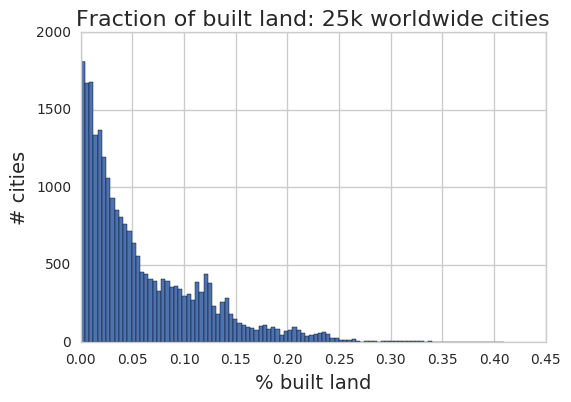

In [37]:
files_df['built pct'].hist(bins=100, figsize=(6,4))
plt.title("Fraction of built land: 25k worldwide cities", fontsize=16)
plt.xlabel("% built land", fontsize=14)
plt.ylabel("# cities", fontsize=14)

In [49]:
q = files_df['built pct'].quantile(np.linspace(0.1,1,10))
files_df['decile'] = files_df['built pct'].apply(lambda x: np.searchsorted(q.values, x) )

#### Split into training and validation

In [51]:
idx = np.random.choice(range(len(files_df)), int(len(files_df)*0.95), \
                       replace=False)
train_df = files_df.iloc[idx]
valid_df  = files_df.iloc[list(set(range(len(files_df))) - set(idx))]

train_df.to_csv(dataroot + "/train.csv")
valid_df.to_csv(dataroot + "/valid.csv")

len(train_df), len(valid_df)

(23786, 1252)

#### Test data is under ./test/ and contains more carefully-filtered samples

In [12]:
import glob

files = glob.glob(dataroot + "/test/*/*.png")
test_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    test_df.append((f, cls, country, pop))
    
test_df = pd.DataFrame(test_df, \
                columns=["filename", "class", "country", "population"])

len(test_df)

3071

In [52]:
test_df['built pct'] = test_df['filename'].apply(compute_built_area)

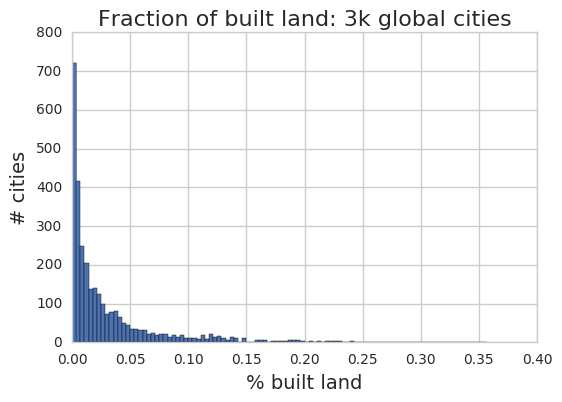

In [53]:
test_df['built pct'].hist(bins=100, figsize=(6,4))
plt.title("Fraction of built land: 3k global cities", fontsize=16)
plt.xlabel("% built land", fontsize=14)
plt.ylabel("# cities", fontsize=14)

In [54]:
test_df['decile'] = test_df['built pct'].apply(lambda x: np.searchsorted(q.values, x) )

# Train GAN -- done externally
We could spawn external process, but better just copy the command into an external script and run in a separate terminal. 

In [85]:
import sys
sys.path.append("/home/adalbert/nbserver/urbanization-patterns/models/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader, default_loader

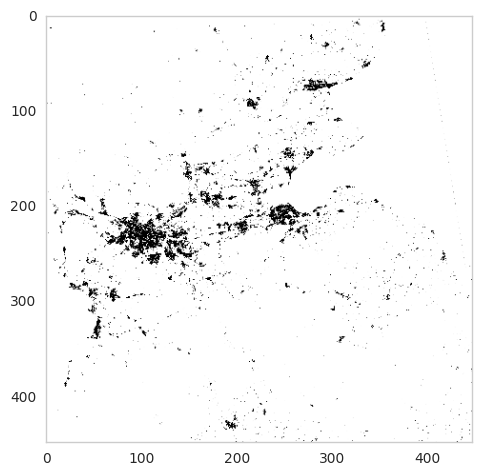

In [182]:
val_nodata = 128

pimg = grayscale_loader(train_df['filename'].iloc[0])

plt.imshow(pimg)

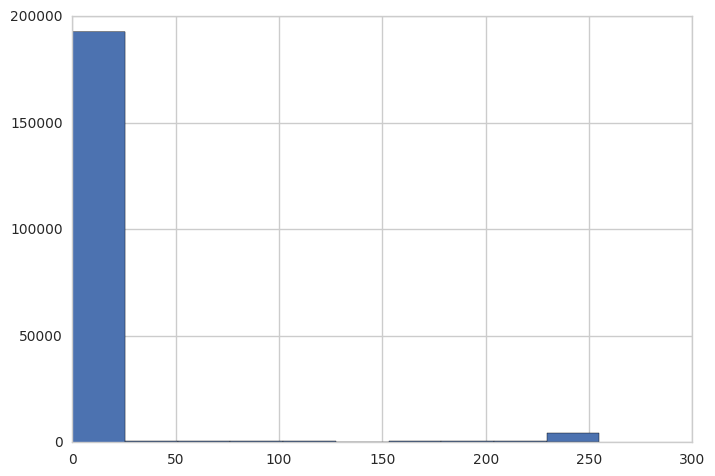

In [185]:
pd.Series(np.array(pimg).flatten()).hist()

# Plot fake and real samples

In [154]:
experiment_dir = "/home/adalbert/nbserver/pytorch-workspace/SAR-WGAN/25k-cities-128-adam//"

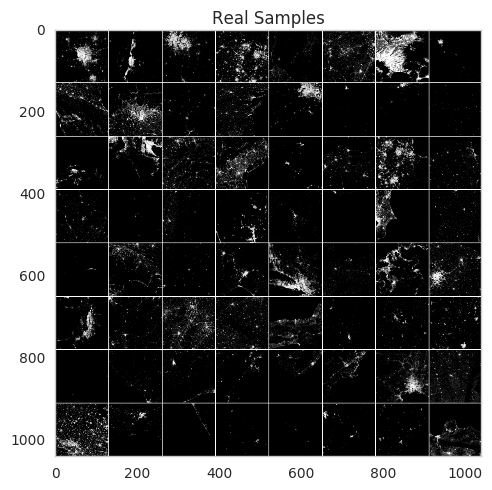

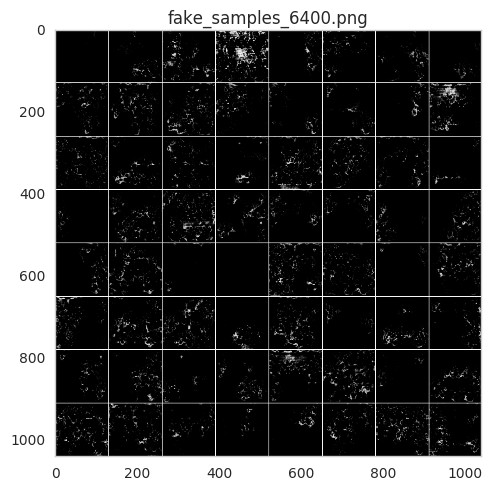

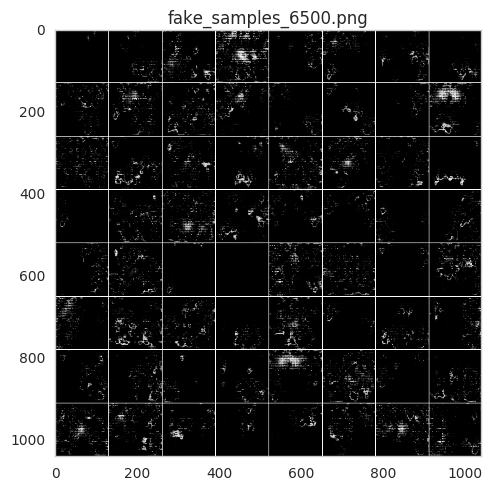

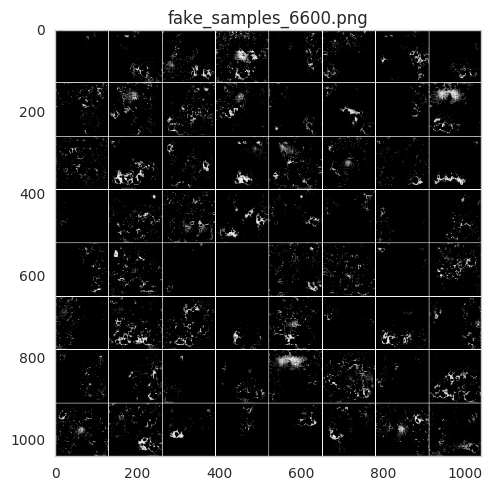

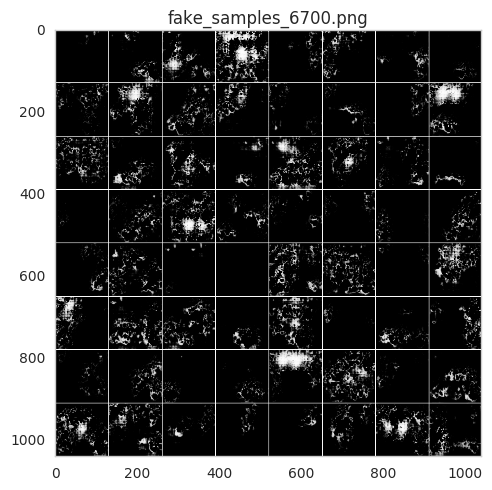

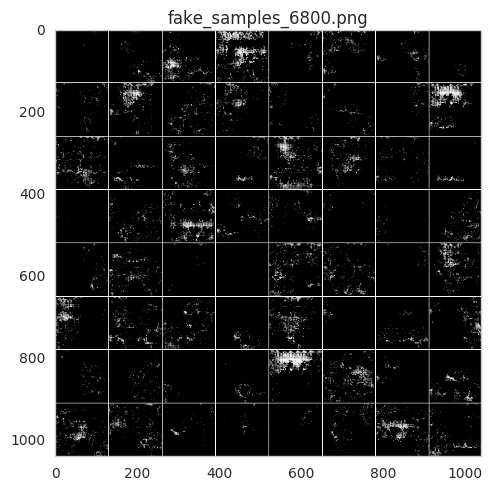

In [210]:
files_fake = glob.glob(experiment_dir + "/fake*.png")
files_fake.sort(key=lambda x: int(os.path.basename(x).split("_")[-1].replace(".png","")))

files_real = glob.glob(experiment_dir + "/real*.png")

files_cptD = glob.glob(experiment_dir + "/netD*.pth")
files_cptD.sort()
files_cptG = glob.glob(experiment_dir + "/netG*.pth")
files_cptG.sort()

plt.imshow(imread(files_real[0]))
plt.title("Real Samples")
plt.show()

for f in files_fake[-5:]:
    img = imread(f)
    plt.imshow(img)
    plt.title(os.path.basename(f))
    plt.show()

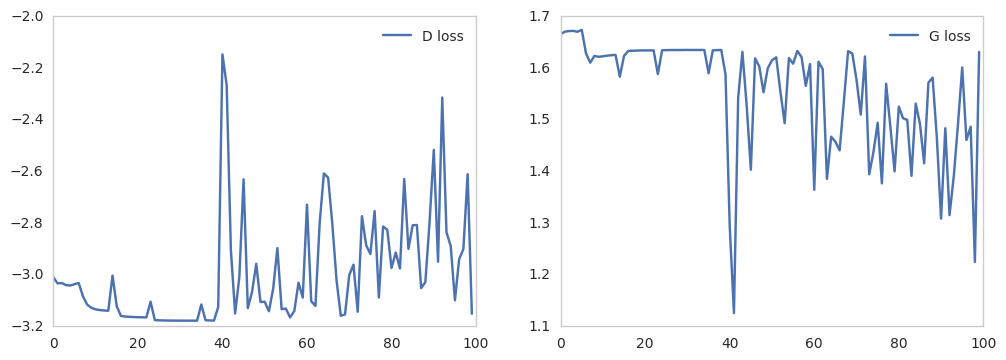

In [208]:
import cPickle as pickle
import gzip

with gzip.open(experiment_dir + "./training-loss.pickle.gz", "r") as f:
    lossD, lossG = pickle.load(f)
    
lossD = np.array(lossD)
lossG = np.array(lossG)

# plot
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(lossD[:,0], label="D loss")
ax[0].legend()
ax[1].plot(lossG[:,0], label="G loss")
ax[1].legend()

# Clustering with GAN generator features

In [ ]:
files_cptD = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptD}

files_cptG = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptG}

In [ ]:
netD.load_state_dict(torch.load(files_cptD[max(files_cptD.keys())]))

feature_extractor = nn.Sequential(*list(list(netD.children())[0].children())[:-2])

In [ ]:
sys.path.append("../pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader

dataset = ImageDataFrame(df=test_df,
                         loader=grayscale_loader,
                         transform=transforms.Compose([
                               transforms.Scale(opt.imageSize),
                               transforms.CenterCrop(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

assert dataset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                     shuffle=False, num_workers=int(opt.workers))


In [ ]:
from torch.autograd import Variable

input = torch.FloatTensor(opt.batchSize, nc, opt.imageSize, opt.imageSize)

if opt.cuda:
    netD.cuda()
    input = input.cuda()

input = Variable(input)

In [ ]:
labels = []
features = []
for i, data in enumerate(dataloader):
    netD.zero_grad()
    real_cpu, lab_batch = data
    batch_size = real_cpu.size(0)
    input.data.resize_(real_cpu.size()).copy_(real_cpu)
    feat_batch = feature_extractor(input)
    feat_batch = feat_batch.data.cpu().numpy().reshape((batch_size,-1))
    
    features.append(feat_batch)
    labels.append(lab_batch.numpy())

features = np.vstack(features)
labels = np.hstack(labels)

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=50)

feat_reduced = pca.fit_transform(features)[:,:40]

plt.figure(figsize=(4,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA Components Variance Explained")
plt.xlabel("# components")
plt.ylabel("% variance")

In [ ]:
# # https://github.com/DmitryUlyanov/Multicore-TSNE

# from MulticoreTSNE import MulticoreTSNE as TSNE

# tsne = TSNE(n_components=20, perplexity=30)
# feats_tsne = tsne.fit_transform(features.astype(np.float64))

In [ ]:
from sklearn.cluster import KMeans
loss_vec = []
k_vec = np.linspace(5, 150, 40)
for k in k_vec:
    print int(k),
    kmeans = KMeans(n_clusters=int(k), random_state=0).fit(feat_reduced)
    loss = -kmeans.score(feat_reduced)
    loss_vec.append(loss)

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(k_vec, np.array(loss_vec)/1e6)
plt.title("K-Means loss vs # clusters")
plt.xlabel("# Clusters")
plt.ylabel("loss (/1e6)")

In [ ]:
kmeans = KMeans(n_clusters=25, random_state=0).fit(feat_reduced)

C = kmeans.predict(feat_reduced)

In [ ]:
(pd.Series(C).value_counts() / float(len(C))).plot(kind="barh", figsize=(4,4))
plt.title("Cluster Membership Distribution")
plt.xlabel("pct membership")
plt.ylabel("cluster ID")

In [ ]:
def plot_examples(image_paths, labels, classes=None, \
                  nExamples=10, thumbSize = (64,64), title="example"):
    # build example canvass 
    from skimage.transform import resize
    from skimage.io import imread
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.zeros((thumbSize[0]*nClusters, nExamples*thumbSize[1]))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = imread(image_paths[idx[j]])
            img = img / float(img.max())
            img[abs(img-0.5)<0.01] = 0 # hack to remove no-data patches
            img = 1-img
            img = resize(img, thumbSize)
            canvas[i*thumbSize[0]:(i+1)*thumbSize[0], j*thumbSize[1]:(j+1)*thumbSize[1]] = img
    
    # plot examples of each class
    fig,ax = plt.subplots(1, figsize=(12,10))
    plt.tight_layout()
    print canvas.shape
    ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("-- examples --", fontsize=16)
    ax.set_xlabel("-- land classes --", fontsize=16)
    # Turn off tick labels
    if classes is None: classes = clustLabels
    ax.set_xticks([thumbSize[0]*(0.5 + x) for x in range(nClusters)])
    ax.set_xticklabels(classes, fontsize=16, rotation=90)
    ax.set_yticklabels([])
    #plt.axis("off")
    plt.show()

In [ ]:
plot_examples(test_df['filename'].values, C)

In [ ]:
test_df.head()